In [5]:
import os, math, json, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow:", tf.__version__)


TensorFlow: 2.19.0


In [6]:
csv_url = "https://drive.google.com/uc?export=download&id=1hpsqSpfjdqIZWqwd259klQSeaNSe5Trr"

df_raw = pd.read_csv(csv_url)
print("Shape:", df_raw.shape)
df_raw.head()


Shape: (53150, 7)


,Date,Close,Volume USDT,RSI,MACD_Hist,ATR,KAMAO
0,2017-09-21 09:00:00.000,3860.00,74434.891166,49.192454,-48.279697,88.054720,2.495591
1,2017-09-21 10:00:00.000,3871.48,44687.318944,49.233202,-47.780476,87.996283,2.616710
2,2017-09-21 11:00:00.000,3864.95,80546.171672,49.210685,-47.308061,87.897128,2.532239
3,2017-09-21 12:00:00.000,3858.08,90331.531390,49.186948,-46.863233,87.720856,2.447245
4,2017-09-21 13:00:00.000,3856.67,103405.818040,49.182064,-46.425379,87.578086,2.424654


In [7]:
df = df_raw.copy()

df.columns = [c.strip() for c in df.columns]

symbol_cols = [c for c in df.columns if c.lower() in ["symbol", "asset", "coin", "crypto", "name"]]
if symbol_cols:
    sym_col = symbol_cols[0]
    mask = df[sym_col].astype(str).str.upper().str.contains(r"\bBTC\b|BITCOIN|BTC/|BTCUSDT", regex=True)
    df = df[mask].copy()
    print(f"Filtered Bitcoin using column: {sym_col} -> shape:", df.shape)
else:
    print("No symbol column detected; assuming data already Bitcoin-only.")

time_candidates = [c for c in df.columns if c.lower() in ["date", "datetime", "timestamp", "time", "open_time", "close_time"]]
if time_candidates:
    time_col = time_candidates[0]
    df[time_col] = pd.to_datetime(df[time_col], errors="coerce", utc=True)
    df = df.dropna(subset=[time_col]).sort_values(time_col).reset_index(drop=True)
    df = df.set_index(time_col)
else:
    unix_candidates = [c for c in df.columns if c.lower() in ["unix", "epoch"]]
    if unix_candidates:
        ucol = unix_candidates[0]
        df[ucol] = pd.to_datetime(df[ucol], unit="s", errors="coerce", utc=True)
        df = df.dropna(subset=[ucol]).sort_values(ucol).reset_index(drop=True).set_index(ucol)
    else:
        raise ValueError("Tidak menemukan kolom waktu. Tolong sesuaikan bagian deteksi timestamp.")

rename_map = {}
for c in df.columns:
    lc = c.lower()
    if lc == "close":
        rename_map[c] = "Close"
    elif lc == "open":
        rename_map[c] = "Open"
    elif lc == "high":
        rename_map[c] = "High"
    elif lc == "low":
        rename_map[c] = "Low"
    elif "volume" in lc and "quote" not in lc:
        rename_map[c] = "Volume"
df = df.rename(columns=rename_map)

if "Close" not in df.columns:
    close_alt = [c for c in df.columns if c.lower() == "close"]
    if close_alt:
        df = df.rename(columns={close_alt[0]: "Close"})
    else:
        raise ValueError("Kolom 'Close' tidak ditemukan. Cek nama kolom pada dataset.")

df = df.select_dtypes(include=[np.number]).copy()

df = df[~df.index.duplicated(keep="first")].sort_index()

print("Final shape:", df.shape)
df.head()


No symbol column detected; assuming data already Bitcoin-only.
Final shape: (16666, 6)


,Close,Volume,RSI,MACD_Hist,ATR,KAMAO
Date,,,,,,
2017-09-21 09:00:00+00:00,3860.00,74434.891166,49.192454,-48.279697,88.054720,2.495591
2017-09-21 10:00:00+00:00,3871.48,44687.318944,49.233202,-47.780476,87.996283,2.616710
2017-09-21 11:00:00+00:00,3864.95,80546.171672,49.210685,-47.308061,87.897128,2.532239
2017-09-21 12:00:00+00:00,3858.08,90331.531390,49.186948,-46.863233,87.720856,2.447245
2017-09-21 13:00:00+00:00,3856.67,103405.818040,49.182064,-46.425379,87.578086,2.424654


Selected features: ['Close', 'Volume', 'RSI']
Features after rolling FE: ['Close', 'Volume', 'RSI', 'Close_roll_mean_24', 'Close_roll_std_24', 'Close_roll_mean_168', 'Close_roll_std_168']


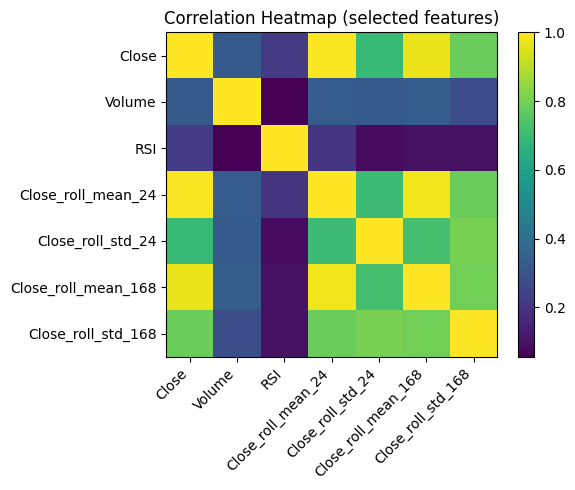

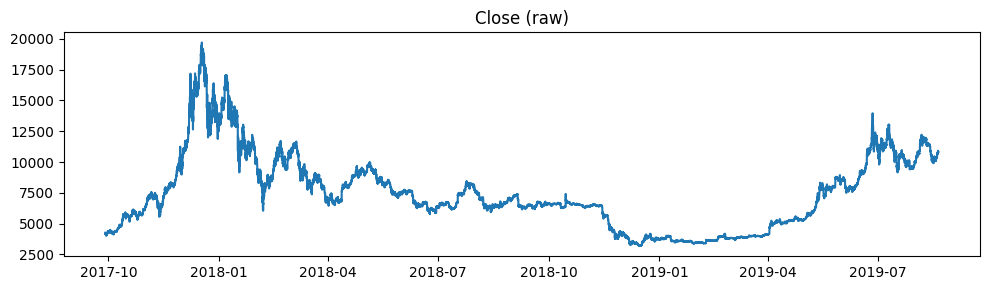

In [8]:
df = df.ffill()

candidate_features = ["Open", "High", "Low", "Close", "Volume"]
features = [c for c in candidate_features if c in df.columns]

if len(features) < 3:
    features = list(df.columns[:3])
    if "Close" not in features and "Close" in df.columns:
        features = (features[:2] + ["Close"])

print("Selected features:", features)

df["Close_roll_mean_24"] = df["Close"].shift(1).rolling(window=24).mean()
df["Close_roll_std_24"]  = df["Close"].shift(1).rolling(window=24).std()
df["Close_roll_mean_168"] = df["Close"].shift(1).rolling(window=168).mean()
df["Close_roll_std_168"]  = df["Close"].shift(1).rolling(window=168).std()

df = df.dropna()

for new_f in ["Close_roll_mean_24","Close_roll_std_24","Close_roll_mean_168","Close_roll_std_168"]:
    if new_f not in features:
        features.append(new_f)

print("Features after rolling FE:", features)


corr = df[features].corr()

plt.figure(figsize=(6,5))
plt.imshow(corr.values, aspect="auto")
plt.xticks(range(len(features)), features, rotation=45, ha="right")
plt.yticks(range(len(features)), features)
plt.colorbar()
plt.title("Correlation Heatmap (selected features)")
plt.tight_layout()
plt.show()

# Plot target Close
plt.figure(figsize=(10,3))
plt.plot(df.index, df["Close"])
plt.title("Close (raw)")
plt.tight_layout()
plt.show()


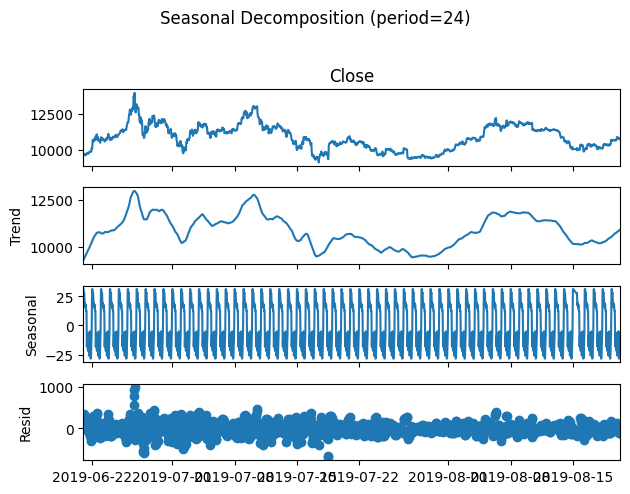

In [9]:
close_series = df["Close"].astype(float)

subset = close_series.iloc[-24*60:] if len(close_series) > 24*60 else close_series

decomp = seasonal_decompose(subset, model="additive", period=24, extrapolate_trend="freq")
decomp.plot()
plt.suptitle("Seasonal Decomposition (period=24)", y=1.02)
plt.tight_layout()
plt.show()


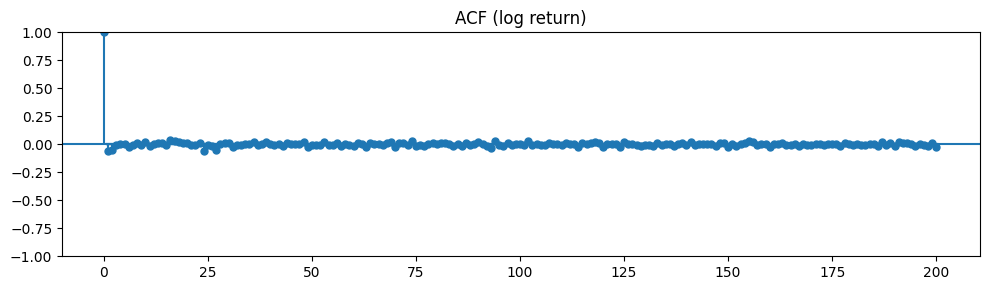

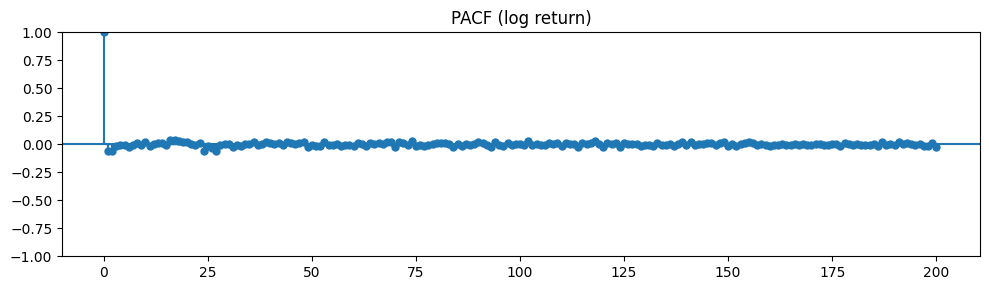

Significant ACF lags (first 30): [  0   1   2   6  10  11  16  17  18  24  26  27  31  36  39  48  49  53
  60  63  69  70  74  75  84  90  93  94  96 102]
Significant PACF lags (first 30): [ 0  1  2  6 10 11 16 17 18 19 20 23 24 26 27 31 36 39 40 44 48 49 53 60
 63 68 69 70 71 74]
INPUT_LEN: 168 HORIZON: 24


In [10]:
eps = 1e-8
log_close = np.log(close_series + eps)
log_ret = log_close.diff().dropna()

fig = plt.figure(figsize=(10,3))
plot_acf(log_ret, lags=200, ax=plt.gca())
plt.title("ACF (log return)")
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(10,3))
plot_pacf(log_ret, lags=200, ax=plt.gca(), method="ywm")
plt.title("PACF (log return)")
plt.tight_layout()
plt.show()


from statsmodels.tsa.stattools import acf, pacf
acf_vals = acf(log_ret, nlags=200, fft=True)
pacf_vals = pacf(log_ret, nlags=200, method="ywm")

conf = 1.96 / np.sqrt(len(log_ret))
sig_acf = np.where(np.abs(acf_vals) > conf)[0]
sig_pacf = np.where(np.abs(pacf_vals) > conf)[0]
print("Significant ACF lags (first 30):", sig_acf[:30])
print("Significant PACF lags (first 30):", sig_pacf[:30])


INPUT_LEN = 168   # 1 minggu (hourly)
HORIZON = 24      # wajib 24-step sesuai kriteria
print("INPUT_LEN:", INPUT_LEN, "HORIZON:", HORIZON)


In [11]:
# Time-based split
n = len(df)
train_end = int(n * 0.70)
val_end = int(n * 0.85)

df_train = df.iloc[:train_end].copy()
df_val   = df.iloc[train_end:val_end].copy()
df_test  = df.iloc[val_end:].copy()

print("Train/Val/Test:", df_train.shape, df_val.shape, df_test.shape)


Train/Val/Test: (11548, 10) (2475, 10) (2475, 10)


In [12]:
class MinMaxScalerPerColumn:
    def __init__(self, eps=1e-8):
        self.eps = eps
        self.min_ = None
        self.max_ = None

    def fit(self, df_):
        self.min_ = df_.min(axis=0)
        self.max_ = df_.max(axis=0)
        return self

    def transform(self, df_):
        return (df_ - self.min_) / (self.max_ - self.min_ + self.eps)

    def inverse_transform_col(self, arr, col_name):
        mn = float(self.min_[col_name])
        mx = float(self.max_[col_name])
        return arr * (mx - mn + self.eps) + mn

scaler = MinMaxScalerPerColumn().fit(df_train[features])
train_scaled = scaler.transform(df_train[features])
val_scaled   = scaler.transform(df_val[features])
test_scaled  = scaler.transform(df_test[features])

# Konversi ke numpy float32
train_np = train_scaled.values.astype(np.float32)
val_np   = val_scaled.values.astype(np.float32)
test_np  = test_scaled.values.astype(np.float32)

close_idx = features.index("Close") if "Close" in features else 0
print("close_idx:", close_idx)


close_idx: 0


In [13]:
def make_baseline_ds(array_2d, input_len, horizon, batch_size, shuffle=True):
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=array_2d,
        targets=None,
        sequence_length=input_len + horizon,
        sequence_stride=1,
        shuffle=shuffle,
        batch_size=batch_size,
    )
    def split_window(window):
        x = window[:, :input_len, :]
        y = window[:, input_len:, close_idx:close_idx+1]
        return x, y
    return ds.map(split_window).prefetch(tf.data.AUTOTUNE)

def make_seq2seq_ds(array_2d, input_len, horizon, batch_size, shuffle=True):
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=array_2d,
        targets=None,
        sequence_length=input_len + horizon,
        sequence_stride=1,
        shuffle=shuffle,
        batch_size=batch_size,
    )
    def split_window(window):
        enc_in = window[:, :input_len, :]  # [B, input_len, F]
        y = window[:, input_len:, close_idx:close_idx+1]  # [B, horizon, 1]
        start = tf.zeros_like(y[:, :1, :])
        dec_in = tf.concat([start, y[:, :-1, :]], axis=1)  # teacher forcing
        return (enc_in, dec_in), y
    return ds.map(split_window).prefetch(tf.data.AUTOTUNE)

BATCH_SIZE = 64

train_base = make_baseline_ds(train_np, INPUT_LEN, HORIZON, BATCH_SIZE, shuffle=True)
val_base   = make_baseline_ds(val_np,   INPUT_LEN, HORIZON, BATCH_SIZE, shuffle=False)
test_base  = make_baseline_ds(test_np,  INPUT_LEN, HORIZON, BATCH_SIZE, shuffle=False)

train_s2s = make_seq2seq_ds(train_np, INPUT_LEN, HORIZON, BATCH_SIZE, shuffle=True)
val_s2s   = make_seq2seq_ds(val_np,   INPUT_LEN, HORIZON, BATCH_SIZE, shuffle=False)
test_s2s  = make_seq2seq_ds(test_np,  INPUT_LEN, HORIZON, BATCH_SIZE, shuffle=False)

# sanity check
(xb, yb) = next(iter(train_base))
print("Baseline x,y:", xb.shape, yb.shape)

((encb, decb), ys) = next(iter(train_s2s))
print("Seq2Seq enc,dec,y:", encb.shape, decb.shape, ys.shape)


Baseline x,y: (64, 168, 7) (64, 24, 1)
Seq2Seq enc,dec,y: (64, 168, 7) (64, 24, 1) (64, 24, 1)


In [14]:
@tf.keras.utils.register_keras_serializable(package="custom")
class CustomDense(tf.keras.layers.Layer):
    def __init__(self, units, use_bias=True, **kwargs):
        super().__init__(**kwargs)
        self.units = int(units)
        self.use_bias = bool(use_bias)

    def build(self, input_shape):
        last_dim = int(input_shape[-1])
        self.w = self.add_weight(
            name="w", shape=(last_dim, self.units),
            initializer="glorot_uniform", trainable=True
        )
        if self.use_bias:
            self.b = self.add_weight(
                name="b", shape=(self.units,),
                initializer="zeros", trainable=True
            )
        else:
            self.b = None

    def call(self, x):
        y = tf.linalg.matmul(x, self.w)
        if self.b is not None:
            y = y + self.b
        return y

    def get_config(self):
        cfg = super().get_config()
        cfg.update({"units": self.units, "use_bias": self.use_bias})
        return cfg


@tf.keras.utils.register_keras_serializable(package="custom")
class CustomLayerNorm(tf.keras.layers.Layer):
    def __init__(self, eps=1e-5, **kwargs):
        super().__init__(**kwargs)
        self.eps = float(eps)

    def build(self, input_shape):
        dim = int(input_shape[-1])
        self.gamma = self.add_weight(name="gamma", shape=(dim,), initializer="ones", trainable=True)
        self.beta  = self.add_weight(name="beta",  shape=(dim,), initializer="zeros", trainable=True)

    def call(self, x):
        mean = tf.reduce_mean(x, axis=-1, keepdims=True)
        var  = tf.reduce_mean(tf.square(x - mean), axis=-1, keepdims=True)
        xhat = (x - mean) / tf.sqrt(var + self.eps)
        return self.gamma * xhat + self.beta

    def get_config(self):
        cfg = super().get_config()
        cfg.update({"eps": self.eps})
        return cfg


@tf.keras.utils.register_keras_serializable(package="custom")
class CustomMultiHeadAttention(tf.keras.layers.Layer):
    """Scaled dot-product multi-head attention (minimal, dari nol)."""
    def __init__(self, num_heads, key_dim, dropout=0.0, **kwargs):
        super().__init__(**kwargs)
        self.num_heads = int(num_heads)
        self.key_dim = int(key_dim)
        self.dropout = float(dropout)

        self.q_proj = None
        self.k_proj = None
        self.v_proj = None
        self.out_proj = None
        self.drop = tf.keras.layers.Dropout(self.dropout)

    def build(self, input_shape):
        self.q_proj = CustomDense(self.num_heads * self.key_dim, name="q_proj")
        self.k_proj = CustomDense(self.num_heads * self.key_dim, name="k_proj")
        self.v_proj = CustomDense(self.num_heads * self.key_dim, name="v_proj")
        self.out_proj = CustomDense(self.num_heads * self.key_dim, name="out_proj")

    def _split_heads(self, x):
        # x: [B, T, H*D] -> [B, H, T, D]
        b = tf.shape(x)[0]
        t = tf.shape(x)[1]
        x = tf.reshape(x, [b, t, self.num_heads, self.key_dim])
        return tf.transpose(x, [0, 2, 1, 3])

    def _combine_heads(self, x):
        # x: [B, H, T, D] -> [B, T, H*D]
        x = tf.transpose(x, [0, 2, 1, 3])
        b = tf.shape(x)[0]
        t = tf.shape(x)[1]
        return tf.reshape(x, [b, t, self.num_heads * self.key_dim])

    def call(self, query, key, value, training=False, mask=None):
        # query/key/value: [B, Tq/Tk, C]
        q = self._split_heads(self.q_proj(query))
        k = self._split_heads(self.k_proj(key))
        v = self._split_heads(self.v_proj(value))

        # attention scores: [B, H, Tq, Tk]
        scale = tf.cast(self.key_dim, tf.float32) ** -0.5
        scores = tf.matmul(q, k, transpose_b=True) * scale

        if mask is not None:
            scores = tf.where(mask, scores, tf.fill(tf.shape(scores), tf.constant(-1e9)))

        weights = tf.nn.softmax(scores, axis=-1)
        weights = self.drop(weights, training=training)

        ctx = tf.matmul(weights, v)  # [B, H, Tq, D]
        ctx = self._combine_heads(ctx)  # [B, Tq, H*D]
        out = self.out_proj(ctx)
        return out

    def get_config(self):
        cfg = super().get_config()
        cfg.update({
            "num_heads": self.num_heads,
            "key_dim": self.key_dim,
            "dropout": self.dropout
        })
        return cfg


In [15]:
F = len(features)
ATTN_HEADS = 4
KEY_DIM = 32


inputs = keras.Input(shape=(INPUT_LEN, F), name="baseline_in")
x = CustomLayerNorm(name="baseline_ln_in")(inputs)

x = keras.layers.LSTM(128, return_sequences=True, name="baseline_lstm")(x)
attn = CustomMultiHeadAttention(ATTN_HEADS, KEY_DIM, dropout=0.1, name="baseline_mha")(x, x, x)
x = CustomLayerNorm(name="baseline_ln_attn")(x + attn)

x = keras.layers.GlobalAveragePooling1D(name="baseline_gap")(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(128, activation="relu")(x)

x = keras.layers.Dense(HORIZON, activation=None, name="baseline_out_vec")(x)
outputs = keras.layers.Reshape((HORIZON, 1), name="baseline_out")(x)

baseline_model = keras.Model(inputs, outputs, name="model_baseline_LSTM")
baseline_model.summary()


Model: "model_baseline_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ baseline_in         │ (None, 168, 7)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ baseline_ln_in      │ (None, 168, 7)    │         14 │ baseline_in[0][0] │
│ (CustomLayerNorm)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ baseline_lstm       │ (None, 168, 128)  │     69,632 │ baseline_ln_in[0… │
│ (LSTM)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ baseline_mha        │ (None, 168, 128)  │     66,048 │ baseline_lstm[0]… │
│ (CustomMultiHeadAt… │                   │            │ baseline_lstm[0]… │
│                     │                   │            │ baseline_lstm[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 168, 128)  │          0 │ baseline_lstm[0]… │
│                     │                   │            │ baseline_mha[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ baseline_ln_attn    │ (None, 168, 128)  │        256 │ add[0][0]         │
│ (CustomLayerNorm)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ baseline_gap        │ (None, 128)       │          0 │ baseline_ln_attn… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ baseline_gap[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ baseline_out_vec    │ (None, 24)        │      3,096 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ baseline_out        │ (None, 24, 1)     │          0 │ baseline_out_vec… │
│ (Reshape)           │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 155,558 (607.65 KB)

 Trainable params: 155,558 (607.65 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
baseline_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.Huber(),
    metrics=[keras.metrics.MeanAbsoluteError(name="mae")]
)

es = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss")

history = baseline_model.fit(
    train_base,
    validation_data=val_base,
    epochs=30,
    callbacks=[es],
    verbose=1
)

baseline_model.save("model_baseline_LSTM.keras")
print("Saved: model_baseline_LSTM.keras")


Epoch 1/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 0.0475 - mae: 0.2059 - val_loss: 6.4802e-04 - val_mae: 0.0273
Epoch 2/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0027 - mae: 0.0549 - val_loss: 7.4907e-04 - val_mae: 0.0301
Epoch 3/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0018 - mae: 0.0442 - val_loss: 4.1428e-04 - val_mae: 0.0215
Epoch 4/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0014 - mae: 0.0397 - val_loss: 5.5883e-04 - val_mae: 0.0256
Epoch 5/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0012 - mae: 0.0367 - val_loss: 3.3674e-04 - val_mae: 0.0197
Epoch 6/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0010 - mae: 0.0334 - val_loss: 1.8730e-04 - val_mae: 0.0155
Epoch 7/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 8.0425e-04 - mae: 0.0301 - val_loss: 2.2168e-04 - val_mae: 0.0164
Epoch 8/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 7.1094e-04 - mae: 0.0282 - val_loss: 3.4077e-04 - val_mae: 0.0202
Epoch 9

In [17]:
enc_in = keras.Input(shape=(INPUT_LEN, F), name="enc_in")
dec_in = keras.Input(shape=(HORIZON, 1), name="dec_in")

enc_norm = CustomLayerNorm(name="s2s_func_ln_enc")(enc_in)
enc_seq, h, c = keras.layers.LSTM(128, return_sequences=True, return_state=True, name="s2s_func_encoder")(enc_norm)

dec_seq, _, _ = keras.layers.LSTM(128, return_sequences=True, return_state=True, name="s2s_func_decoder")(dec_in, initial_state=[h, c])

ctx = CustomMultiHeadAttention(ATTN_HEADS, KEY_DIM, dropout=0.1, name="s2s_func_mha")(dec_seq, enc_seq, enc_seq)
dec_mix = CustomLayerNorm(name="s2s_func_ln_ctx")(dec_seq + ctx)

out = CustomDense(1, name="s2s_func_custom_dense")(dec_mix)
seq2seq_func_model = keras.Model([enc_in, dec_in], out, name="seq2seq_lstm_model_functional")
seq2seq_func_model.summary()


Model: "seq2seq_lstm_model_functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ enc_in (InputLayer) │ (None, 168, 7)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ s2s_func_ln_enc     │ (None, 168, 7)    │         14 │ enc_in[0][0]      │
│ (CustomLayerNorm)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_in (InputLayer) │ (None, 24, 1)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ s2s_func_encoder    │ [(None, 168,      │     69,632 │ s2s_func_ln_enc[… │
│ (LSTM)              │ 128), (None,      │            │                   │
│                     │ 128), (None,      │            │                   │
│                     │ 128)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ s2s_func_decoder    │ [(None, 24, 128), │     66,560 │ dec_in[0][0],     │
│ (LSTM)              │ (None, 128),      │            │ s2s_func_encoder… │
│                     │ (None, 128)]      │            │ s2s_func_encoder… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ s2s_func_mha        │ (None, 24, 128)   │     66,048 │ s2s_func_decoder… │
│ (CustomMultiHeadAt… │                   │            │ s2s_func_encoder… │
│                     │                   │            │ s2s_func_encoder… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 24, 128)   │          0 │ s2s_func_decoder… │
│                     │                   │            │ s2s_func_mha[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ s2s_func_ln_ctx     │ (None, 24, 128)   │        256 │ add_1[0][0]       │
│ (CustomLayerNorm)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ s2s_func_custom_de… │ (None, 24, 1)     │        129 │ s2s_func_ln_ctx[… │
│ (CustomDense)       │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 202,639 (791.56 KB)

 Trainable params: 202,639 (791.56 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
@tf.keras.utils.register_keras_serializable(package="custom")
class Seq2SeqSubclass(tf.keras.Model):
    def __init__(self, enc_units=128, dec_units=128, num_heads=4, key_dim=16, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.enc_units = int(enc_units)
        self.dec_units = int(dec_units)
        self.num_heads = int(num_heads)
        self.key_dim = int(key_dim)
        self.dropout = float(dropout)

        self.enc_ln = CustomLayerNorm(name="s2s_ln_enc")
        self.encoder = keras.layers.LSTM(self.enc_units, return_sequences=True, return_state=True, name="s2s_encoder")

        self.decoder_cell = keras.layers.LSTMCell(self.dec_units, name="s2s_decoder_cell")
        self.decoder_rnn = keras.layers.RNN(self.decoder_cell, return_sequences=True, return_state=True, name="s2s_decoder_rnn")

        self.mha = CustomMultiHeadAttention(self.num_heads, self.key_dim, dropout=self.dropout, name="s2s_mha")
        self.post_ln = CustomLayerNorm(name="s2s_ln_post")

        self.out_dense = CustomDense(1, name="s2s_out_dense")

    def call(self, inputs, training=False):
        enc_in, dec_in = inputs
        enc_in = self.enc_ln(enc_in)
        enc_seq, h, c = self.encoder(enc_in, training=training)

        dec_seq, _, _ = self.decoder_rnn(dec_in, initial_state=[h, c], training=training)

        ctx = self.mha(dec_seq, enc_seq, enc_seq, training=training)
        mix = self.post_ln(dec_seq + ctx)
        y = self.out_dense(mix)
        return y

    def infer_autoregressive(self, enc_in, horizon, training=False):
        """Autoregressive decoding tanpa teacher forcing."""
        enc_in = self.enc_ln(enc_in)
        enc_seq, h, c = self.encoder(enc_in, training=training)

        batch = tf.shape(enc_in)[0]
        x_t = tf.zeros([batch, 1], dtype=enc_in.dtype)  # input to LSTMCell: [B, 1]
        state = [h, c]

        preds = []
        for _ in range(horizon):
            out_t, state = self.decoder_cell(x_t, state, training=training)  # out_t: [B, dec_units]
            out_t_seq = tf.expand_dims(out_t, axis=1)  # [B, 1, dec_units]
            ctx_t = self.mha(out_t_seq, enc_seq, enc_seq, training=training)  # [B, 1, dec_units]
            mix_t = self.post_ln(out_t_seq + ctx_t)  # [B, 1, dec_units]
            y_t = self.out_dense(mix_t)  # [B, 1, 1]
            preds.append(y_t)
            x_t = tf.squeeze(y_t, axis=-1)[:, 0:1]  # [B, 1]
        return tf.concat(preds, axis=1)  # [B, horizon, 1]

    def get_config(self):
        cfg = super().get_config()
        cfg.update({
            "enc_units": self.enc_units,
            "dec_units": self.dec_units,
            "num_heads": self.num_heads,
            "key_dim": self.key_dim,
            "dropout": self.dropout,
        })
        return cfg

seq2seq_model = Seq2SeqSubclass(enc_units=128, dec_units=128, num_heads=ATTN_HEADS, key_dim=KEY_DIM, dropout=0.1, name="seq2seq_lstm_model")
# build once
((encb, decb), ys) = next(iter(train_s2s))
_ = seq2seq_model((encb, decb), training=False)
seq2seq_model.summary()


Model: "seq2seq_lstm_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ s2s_ln_enc (CustomLayerNorm)    │ ?                      │            14 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ s2s_encoder (LSTM)              │ ((64, 168, 128), (64,  │        69,632 │
│                                 │ 128), (64, 128))       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ s2s_decoder_cell (LSTMCell)     │ ?                      │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ s2s_decoder_rnn (RNN)           │ ((64, 24, 128), (64,   │        66,560 │
│                                 │ 128), (64, 128))       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ s2s_mha                         │ ?                      │        66,048 │
│ (CustomMultiHeadAttention)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ s2s_ln_post (CustomLayerNorm)   │ ?                      │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ s2s_out_dense (CustomDense)     │ ?                      │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202,639 (791.56 KB)

 Trainable params: 202,639 (791.56 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
def custom_mae(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

h_weights = tf.linspace(1.0, 2.0, HORIZON)
h_weights = tf.reshape(h_weights, [1, HORIZON, 1])

def weighted_horizon_mae(y_true, y_pred):
    err = tf.abs(y_true - y_pred) * h_weights
    return tf.reduce_mean(err)


In [20]:
class CustomEarlyStopping:
    def __init__(self, patience=7, min_delta=0.0):
        self.patience = int(patience)
        self.min_delta = float(min_delta)
        self.best = np.inf
        self.wait = 0
        self.best_weights = None

    def update(self, model, current_val):
        if current_val < (self.best - self.min_delta):
            self.best = current_val
            self.wait = 0
            self.best_weights = model.get_weights()
            return False
        else:
            self.wait += 1
            if self.wait >= self.patience:
                return True
            return False

    def restore_best(self, model):
        if self.best_weights is not None:
            model.set_weights(self.best_weights)


class CustomReduceLROnPlateau:
    def __init__(self, optimizer, factor=0.5, patience=3, min_lr=1e-6, min_delta=0.0):
        self.optimizer = optimizer
        self.factor = float(factor)
        self.patience = int(patience)
        self.min_lr = float(min_lr)
        self.min_delta = float(min_delta)

        self.best = np.inf
        self.wait = 0

    def step(self, current_val):
        if current_val < (self.best - self.min_delta):
            self.best = current_val
            self.wait = 0
            return
        self.wait += 1
        if self.wait >= self.patience:
            lr_obj = self.optimizer.learning_rate
            old_lr = float(lr_obj.numpy()) if hasattr(lr_obj, "numpy") else float(lr_obj)
            new_lr = max(old_lr * self.factor, self.min_lr)
            if hasattr(lr_obj, "assign"):
                dtype = tf.as_dtype(getattr(lr_obj, "dtype", "float32"))
                lr_obj.assign(tf.cast(new_lr, dtype))
            else:
                self.optimizer.learning_rate = new_lr
            print(f"  [LR Scheduler] val_loss stagnan -> lr {old_lr:.2e} -> {new_lr:.2e}")
            self.wait = 0


In [21]:
@tf.function(reduce_retracing=True)
def train_step(model, optimizer, x, y, loss_fn):
    with tf.GradientTape() as tape:
        y_pred = model(x, training=True)
        loss = loss_fn(y, y_pred)

    grads = tape.gradient(loss, model.trainable_variables)

    grads_vars = [(g, v) for g, v in zip(grads, model.trainable_variables) if g is not None]
    optimizer.apply_gradients(grads_vars)
    return loss

@tf.function(reduce_retracing=True)
def val_step(model, x, y, loss_fn):
    y_pred = model(x, training=False)
    loss = loss_fn(y, y_pred)
    return loss

def _force_build_model_and_optimizer(model, train_ds, optimizer):
    for x0, y0 in train_ds.take(1):
        _ = model(x0, training=False)
        break

    if hasattr(optimizer, "build"):
        optimizer.build(model.trainable_variables)

def run_custom_training(model, train_ds, val_ds, optimizer, loss_fn, epochs=30, patience=7):
    _force_build_model_and_optimizer(model, train_ds, optimizer)

    early = CustomEarlyStopping(patience=patience, min_delta=1e-5)
    lr_sched = CustomReduceLROnPlateau(optimizer, factor=0.5, patience=3, min_lr=1e-6, min_delta=1e-5)

    for epoch in range(1, epochs+1):
        train_losses = []
        for x, y in train_ds:
            loss = train_step(model, optimizer, x, y, loss_fn)
            train_losses.append(loss.numpy())
        tr = float(np.mean(train_losses))

        val_losses = []
        for x, y in val_ds:
            loss = val_step(model, x, y, loss_fn)
            val_losses.append(loss.numpy())
        vl = float(np.mean(val_losses))

        lr_now = optimizer.learning_rate
        lr_now = float(lr_now.numpy()) if hasattr(lr_now, "numpy") else float(lr_now)
        print(f"Epoch {epoch:03d} | loss={tr:.6f} | val_loss={vl:.6f} | lr={lr_now:.2e}")

        lr_sched.step(vl)
        if early.update(model, vl):
            print("Early stopping triggered.")
            break

    early.restore_best(model)
    return early.best


In [22]:
baseline_optimizer = keras.optimizers.Adam(learning_rate=5e-4)

best_val_baseline = run_custom_training(
    baseline_model,
    train_base,
    val_base,
    optimizer=baseline_optimizer,
    loss_fn=weighted_horizon_mae,
    epochs=20,
    patience=6
)

baseline_model.save("model_baseline_LSTM.keras")
print("Saved (updated): model_baseline_LSTM.keras | best val:", best_val_baseline)


Epoch 001 | loss=0.046655 | val_loss=0.041826 | lr=5.00e-04
Epoch 002 | loss=0.040034 | val_loss=0.030926 | lr=5.00e-04
Epoch 003 | loss=0.037609 | val_loss=0.036115 | lr=5.00e-04
Epoch 004 | loss=0.034671 | val_loss=0.036288 | lr=5.00e-04
Epoch 005 | loss=0.034009 | val_loss=0.035596 | lr=5.00e-04
  [LR Scheduler] val_loss stagnan -> lr 5.00e-04 -> 2.50e-04
Epoch 006 | loss=0.030801 | val_loss=0.022967 | lr=2.50e-04
Epoch 007 | loss=0.029144 | val_loss=0.020203 | lr=2.50e-04
Epoch 008 | loss=0.027499 | val_loss=0.028648 | lr=2.50e-04
Epoch 009 | loss=0.026853 | val_loss=0.019831 | lr=2.50e-04
Epoch 010 | loss=0.025860 | val_loss=0.019505 | lr=2.50e-04
Epoch 011 | loss=0.025796 | val_loss=0.032914 | lr=2.50e-04
Epoch 012 | loss=0.025320 | val_loss=0.021426 | lr=2.50e-04
Epoch 013 | loss=0.024851 | val_loss=0.026549 | lr=2.50e-04
  [LR Scheduler] val_loss stagnan -> lr 2.50e-04 -> 1.25e-04
Epoch 014 | loss=0.023549 | val_loss=0.019436 | lr=1.25e-04
Epoch 015 | loss=0.023315 | val_loss=0

In [23]:
seq2seq_optimizer = keras.optimizers.Adam(learning_rate=8e-4)

best_val_s2s = run_custom_training(
    seq2seq_model,
    train_s2s,
    val_s2s,
    optimizer=seq2seq_optimizer,
    loss_fn=weighted_horizon_mae,
    epochs=40,
    patience=8
)

seq2seq_model.save("model_seq2seq_LSTM.keras")
print("Saved: model_seq2seq_LSTM.keras | best val:", best_val_s2s)

seq2seq_model.save("best_model_seq2seq_LSTM.keras")
print("Saved: best_model_seq2seq_LSTM.keras")


Epoch 001 | loss=0.232713 | val_loss=0.121283 | lr=8.00e-04
Epoch 002 | loss=0.082865 | val_loss=0.019576 | lr=8.00e-04
Epoch 003 | loss=0.038689 | val_loss=0.037714 | lr=8.00e-04
Epoch 004 | loss=0.045527 | val_loss=0.010471 | lr=8.00e-04
Epoch 005 | loss=0.039622 | val_loss=0.010682 | lr=8.00e-04
Epoch 006 | loss=0.033127 | val_loss=0.035991 | lr=8.00e-04
Epoch 007 | loss=0.036868 | val_loss=0.008918 | lr=8.00e-04
Epoch 008 | loss=0.026906 | val_loss=0.013344 | lr=8.00e-04
Epoch 009 | loss=0.029033 | val_loss=0.024144 | lr=8.00e-04
Epoch 010 | loss=0.028325 | val_loss=0.006229 | lr=8.00e-04
Epoch 011 | loss=0.029126 | val_loss=0.037379 | lr=8.00e-04
Epoch 012 | loss=0.023266 | val_loss=0.019221 | lr=8.00e-04
Epoch 013 | loss=0.023202 | val_loss=0.006827 | lr=8.00e-04
  [LR Scheduler] val_loss stagnan -> lr 8.00e-04 -> 4.00e-04
Epoch 014 | loss=0.013750 | val_loss=0.004719 | lr=4.00e-04
Epoch 015 | loss=0.011877 | val_loss=0.005524 | lr=4.00e-04
Epoch 016 | loss=0.011589 | val_loss=0.

In [24]:
def eval_mae_on_test_baseline(model, test_ds, horizon):
    maes = []
    for x, y in test_ds:
        y_pred = model(x, training=False)
        maes.append(custom_mae(y, y_pred).numpy())
    return float(np.mean(maes))

def eval_mae_on_test_seq2seq_autoreg(model, test_ds, horizon):
    maes = []
    for (enc_in, dec_in), y in test_ds:
        # autoregressive: hanya pakai enc_in
        y_pred = model.infer_autoregressive(enc_in, horizon=horizon, training=False)
        maes.append(custom_mae(y, y_pred).numpy())
    return float(np.mean(maes))

test_mae_baseline = eval_mae_on_test_baseline(baseline_model, test_base, HORIZON)
test_mae_s2s = eval_mae_on_test_seq2seq_autoreg(seq2seq_model, test_s2s, HORIZON)

print(f"TEST MAE (scaled) - Baseline: {test_mae_baseline:.6f}")
print(f"TEST MAE (scaled) - Seq2Seq autoregressive: {test_mae_s2s:.6f}")



TEST MAE (scaled) - Baseline: 0.112151
TEST MAE (scaled) - Seq2Seq autoregressive: 0.081885


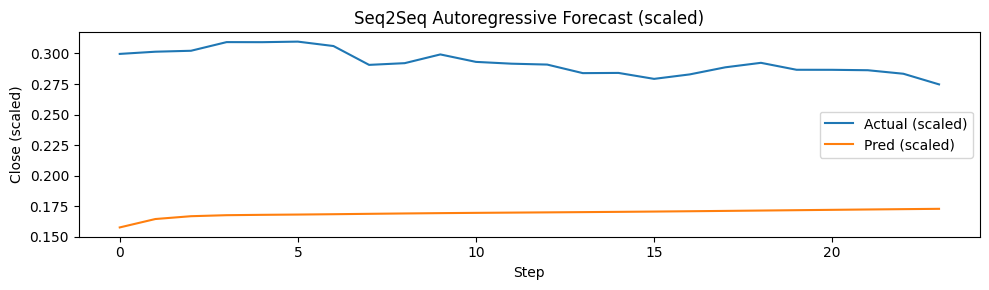

,step,actual_scaled,pred_scaled,abs_error
0,0,0.299640,0.157597,0.142043
1,1,0.301442,0.164482,0.136960
2,2,0.302212,0.166785,0.135427
3,3,0.309299,0.167617,0.141682
4,4,0.309244,0.167912,0.141332
5,5,0.309698,0.168136,0.141562
6,6,0.306089,0.168419,0.137670
7,7,0.290660,0.168736,0.121924
8,8,0.292067,0.169039,0.123028
9,9,0.299214,0.169303,0.129910


In [25]:

(x_test, y_true) = next(iter(test_base))
y_pred_base = baseline_model(x_test, training=False).numpy()

((enc_test, dec_test), y_true_s2s) = next(iter(test_s2s))
y_pred_s2s = seq2seq_model.infer_autoregressive(enc_test, horizon=HORIZON, training=False).numpy()

i = 0
t = np.arange(HORIZON)
actual = y_true_s2s[i, :, 0]
pred = y_pred_s2s[i, :, 0]

plt.figure(figsize=(10,3))
plt.plot(t, actual, label="Actual (scaled)")
plt.plot(t, pred, label="Pred (scaled)")
plt.title("Seq2Seq Autoregressive Forecast (scaled)")
plt.xlabel("Step")
plt.ylabel("Close (scaled)")
plt.legend()
plt.tight_layout()
plt.show()

df_cmp = pd.DataFrame({
    "step": t,
    "actual_scaled": actual,
    "pred_scaled": pred,
    "abs_error": np.abs(actual - pred)
})
df_cmp.head(10)


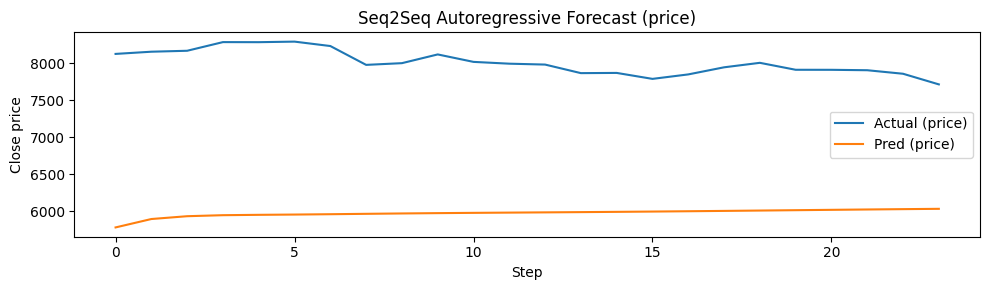

In [26]:
# Inverse scaling hanya untuk kolom Close
actual_price = scaler.inverse_transform_col(actual, "Close")
pred_price   = scaler.inverse_transform_col(pred, "Close")

plt.figure(figsize=(10,3))
plt.plot(t, actual_price, label="Actual (price)")
plt.plot(t, pred_price, label="Pred (price)")
plt.title("Seq2Seq Autoregressive Forecast (price)")
plt.xlabel("Step")
plt.ylabel("Close price")
plt.legend()
plt.tight_layout()
plt.show()
